# 1D MNIST DATA

In [9]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

PROJECT_DIR = './'

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cpu


## Templates


In [10]:
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

## Transformations


In [11]:
# transformations of the templates which will make them harder to fit
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)

## Visualization

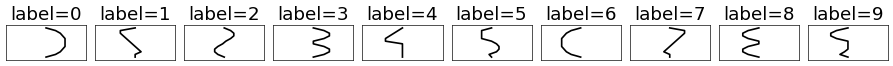

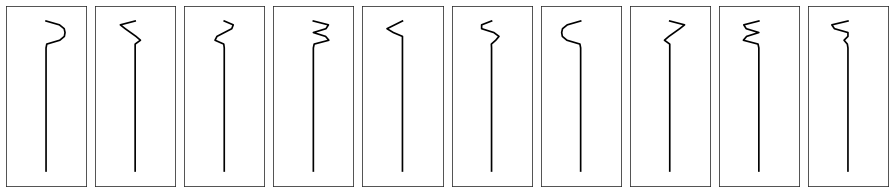

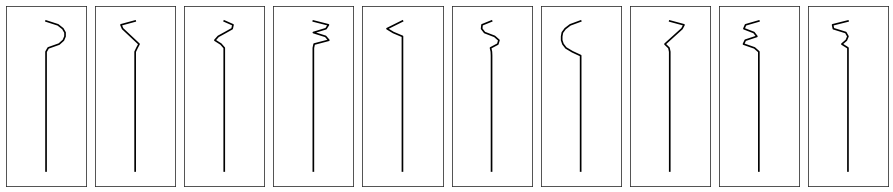

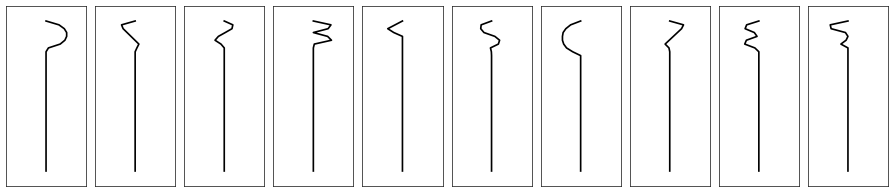

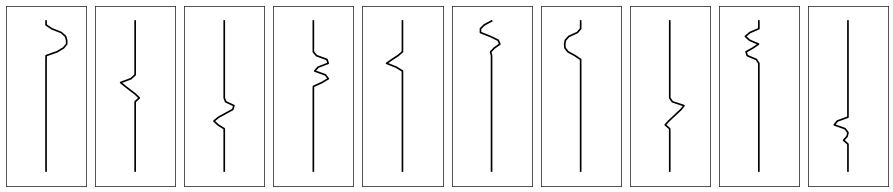

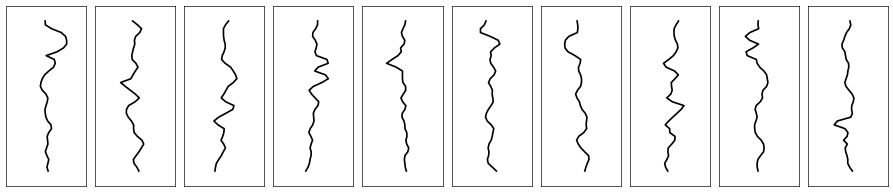

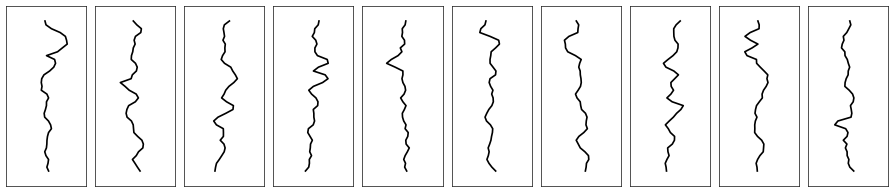

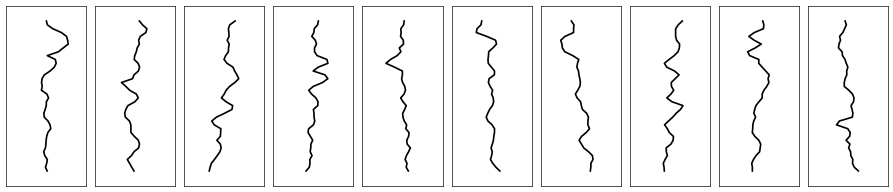

In [12]:
def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

def apply_ablations(arg_dict, n=7):
    ablations = [('shear_scale', 0),
                ('iid_noise_scale', 0),
                ('corr_noise_scale', 0),
                 ('max_translation', 1),
                 ('scale_coeff', 0),
                 ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                 ('padding', [0, 0]),]
    num_ablations = min(n, len(ablations))
    for i in range(num_ablations):
        k, v = ablations[i]
        arg_dict[k] = v
    return arg_dict

templates = get_templates()
for i, n in enumerate(reversed(range(8))):
    np.random.seed(0)
    arg_dict = get_dataset_args(as_dict=True)
    arg_dict = apply_ablations(arg_dict, n=n)
    args = ObjectView(arg_dict)
    do_transform = args.padding[0] != 0
    fig = plot_signals(templates['x'], templates['t'], labels=None if do_transform else templates['y'],
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)
#     fig.savefig(PROJECT_DIR + 'static/transform_{}.png'.format(i))

## Example


In [13]:
from mnist1d.data import make_dataset, get_dataset_args

defaults = get_dataset_args()
data = make_dataset(defaults)
x, y, t = data['x'], data['y'], data['t']

print(data.keys())

print(x.shape)
print(y.shape)
print(t.shape)

dict_keys(['x', 'x_test', 'y', 'y_test', 't', 'templates'])
(4000, 40)
(4000,)
(40,)


In [17]:
print(type(x[0]))

print(x[0].shape)

<class 'numpy.ndarray'>
(40,)


In [40]:
x_modified = torch.tensor(x, dtype = torch.float32)
x_modified

tensor([[-0.3320, -0.4719, -0.7787,  ..., -0.7167, -0.9620, -0.8902],
        [ 1.9655,  2.3002,  2.2134,  ..., -1.6875, -1.4264, -1.3642],
        [-0.0193,  0.0786,  0.6249,  ..., -1.0856, -1.7981, -2.3153],
        ...,
        [-1.6945, -1.2806, -0.6513,  ..., -0.7237, -0.3827, -0.0317],
        [ 0.9965,  0.8084,  0.1553,  ..., -0.3029, -0.2856, -0.1184],
        [-0.6940, -0.2753,  0.2927,  ..., -1.2162, -1.4649, -1.6510]])

In [41]:
x_modified.unsqueeze(1).shape

torch.Size([4000, 1, 40])

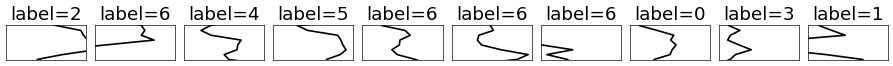

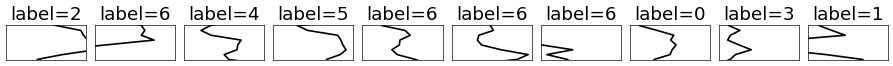

In [75]:
do_transform = False
arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.1,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
args = ObjectView(arg_dict)
plot_signals(x, t, labels=None if do_transform else y,
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)

In [71]:
templates['x'].shape

(10, 12)